In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/fk/rdw6333d6nn246rycbjyc9180000gn/T/ipykernel_90906/687462750.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### How secure a win in the UFC: A Data-Driven Approach to Decision Victories

Introduction

The Ultimate Fighting Championship (UFC) has seen a remarkable growth in popularity, evidenced by the increasing number of events and the expanding roster of fighters. This data-driven analysis focuses on identifying the key factors that contribute to securing a win by decision in UFC fights, exploring how the dynamics of fights have evolved over time, and providing insights into effective strategies for fighters aiming for decision victories.

Objectives
Examine the growth of UFC events over the years.
Analyze trends in fight outcomes, with a focus on decision wins.
Investigate the relationship between the number of fighters and decision win rates.
Uncover the "perfect formula" for securing a decision victory in the UFC.

Data Preparation

The analysis utilizes data from ufc_event_data, ufc_fight_data, fighter_stat  tables, converted to Pandas DataFrames for exploratory data analysis. Key attributes include event details, fight outcomes, and comprehensive fight and fighters statistics.

## Analysis

### UFC Events Growth
The analysis begins with an overview of the UFC's growth, highlighting the increase in the number of events held each year.

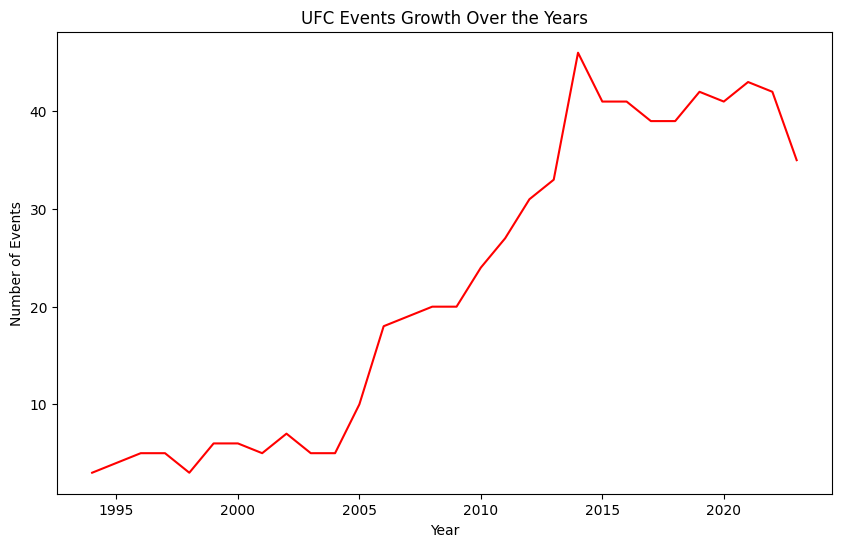

In [2]:
# Load the csv file directly into a pandas dataframe
events_df = pd.read_csv('dataframes/ufc_event_data.csv')

# Convert the event_date column to datetime and extract the year
events_df['year'] = pd.to_datetime(events_df['event_date']).dt.year

# Group by the year and count the number of events per year
events_per_year = events_df.groupby('year').size()

# Plotting the UFC events growth over the years
plt.figure(figsize=(10, 6))
events_per_year.plot(kind='line', color="red")
plt.title('UFC Events Growth Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.grid(False)
plt.show()

### The trend of increased decision wins

As more and more athletes are joining the promotion, the strategy and fight dynamics is changing. Lets see if the popularity of the promotion is motivating fighters to change their approach to secure a win.

We first will look at the bar chart of types of wins in the promotion, then we will analyze if there is a correlation between increased amount of fighters and increased rate decision wins over the years.

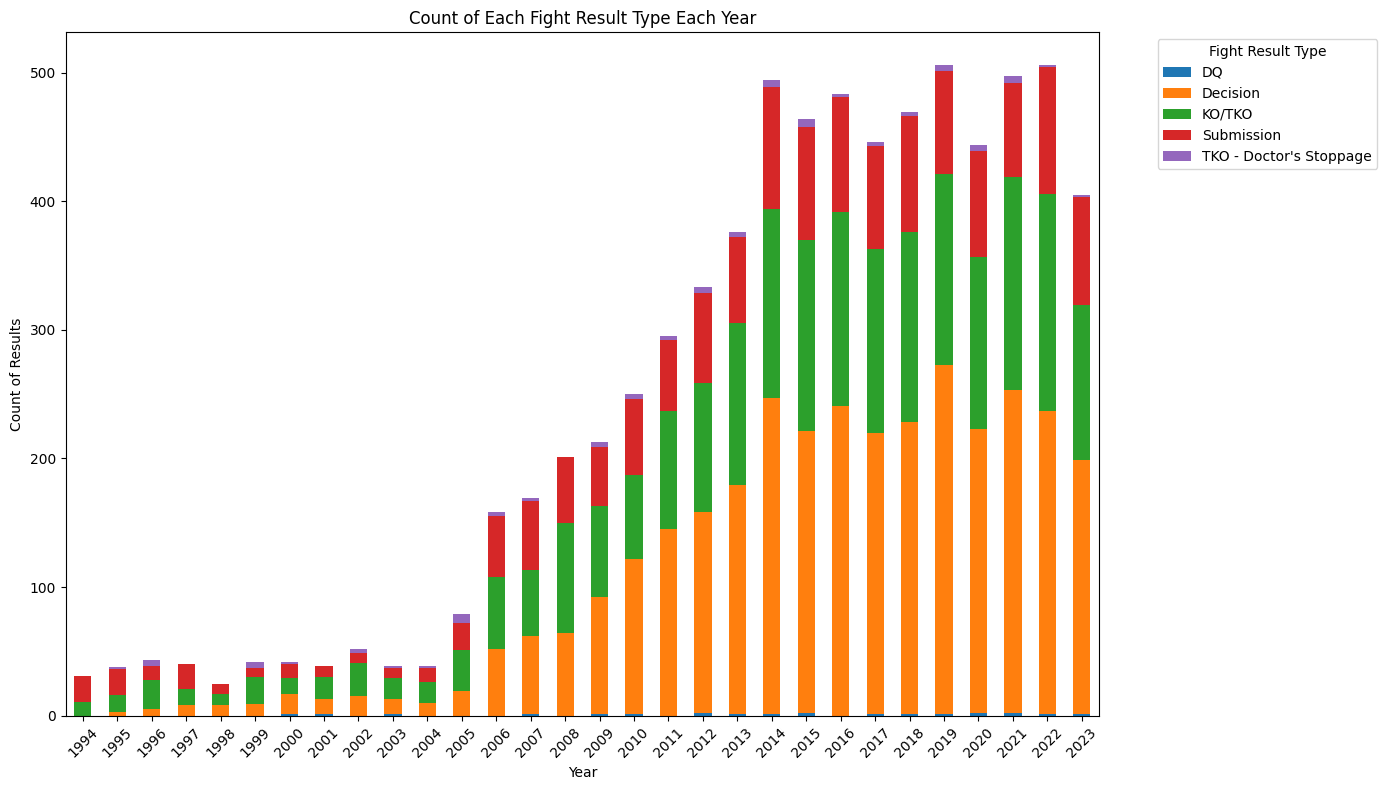

In [3]:
# Load the csv files directly into pandas dataframes
fights_df = pd.read_csv('dataframes/ufc_fight_data.csv')

# Merge the fights dataframe with the events dataframe on 'event_id'
merged_df = pd.merge(fights_df, events_df[['event_id', 'event_date']], on='event_id', how='left')

# Convert the event_date to datetime and extract the year
merged_df['year'] = pd.to_datetime(merged_df['event_date']).dt.year

# Group by year and fight result, then count occurrences
results_by_year = merged_df.groupby(['year', 'result']).size().reset_index(name='count')

# Pivot the results to have the 'result' types as columns
results_pivot = results_by_year.pivot(index='year', columns='result', values='count').fillna(0)

# Plot the results as a stacked bar chart
results_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Count of Each Fight Result Type Each Year')
plt.xlabel('Year')
plt.ylabel('Count of Results')
plt.legend(title='Fight Result Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The correlation between the number of active fighters and decision wins per year is: 0.9888710195739635


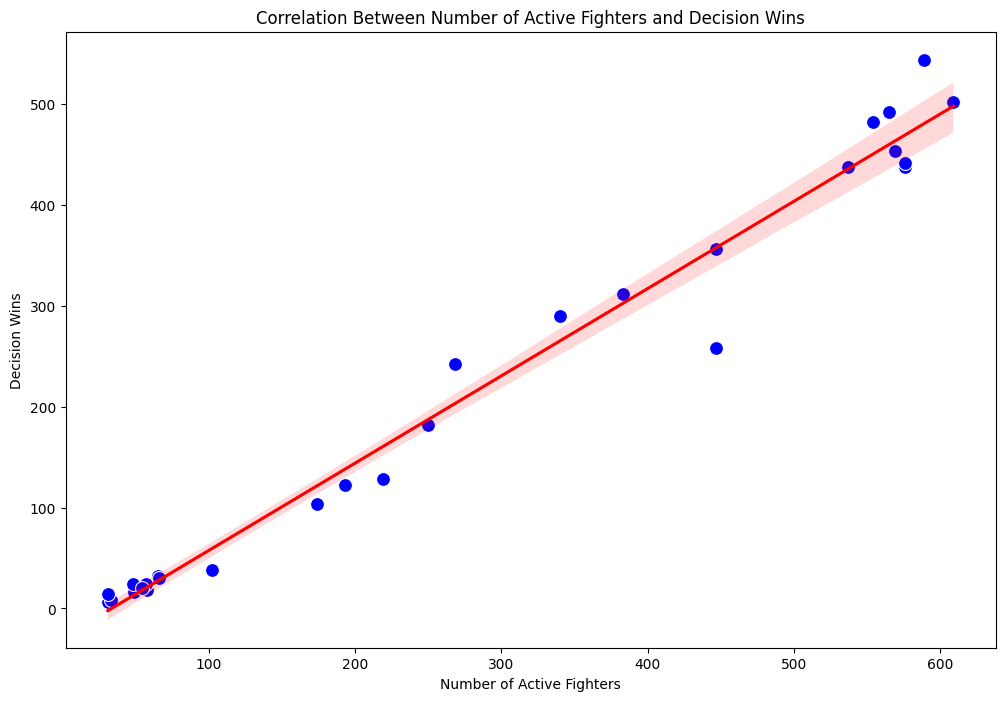

In [4]:
df_fighter_stat = pd.read_csv('dataframes/fighter_stat.csv')
df_fighter_stat['year'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d').dt.year

decision_wins = df_fighter_stat[df_fighter_stat['method'].isin(['U-DEC', 'S-DEC', 'M-DEC'])]
decision_wins_per_year = decision_wins.groupby('year').size().reset_index(name='decision_wins')
fighters_per_year = pd.concat([df_fighter_stat[['year', 'fighter']], df_fighter_stat[['year', 'opponent']].rename(columns={'opponent': 'fighter'})]) \
                    .drop_duplicates() \
                    .groupby('year')['fighter'].nunique() \
                    .reset_index(name='unique_fighters')

#Calculate the correlation between decision wins and the number of unique fighters
data_merged = pd.merge(decision_wins_per_year, fighters_per_year, on='year')
correlation = data_merged['decision_wins'].corr(data_merged['unique_fighters'])
print(f"The correlation between the number of active fighters and decision wins per year is: {correlation}")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data_merged, x='unique_fighters', y='decision_wins', color='blue', s=100)
sns.regplot(data=data_merged, x='unique_fighters', y='decision_wins', scatter=False, color='red')

plt.title('Correlation Between Number of Active Fighters and Decision Wins')
plt.xlabel('Number of Active Fighters')
plt.ylabel('Decision Wins')
plt.show()


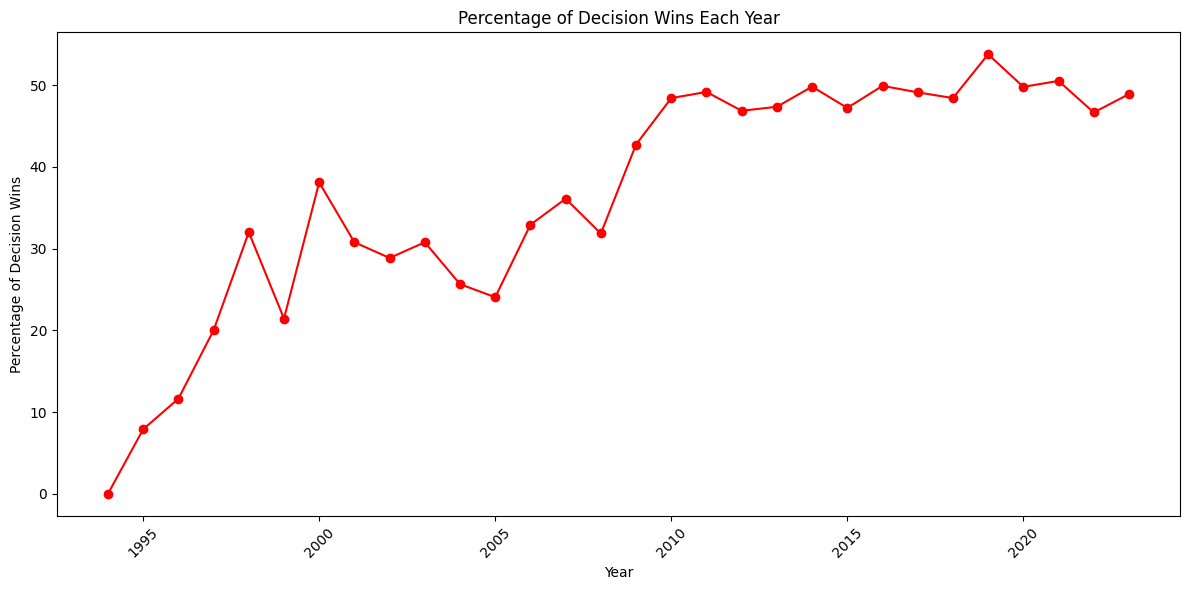

In [5]:
# Plotting the percentage of decision wins each year
results_by_year = merged_df.groupby(['year', 'result']).size().reset_index(name='count')
results_pivot = results_by_year.pivot(index='year', columns='result', values='count').fillna(0)
results_pivot['Total Fights'] = results_pivot.sum(axis=1)
if 'Decision' in results_pivot.columns:
    results_pivot['Percentage of Decisions'] = (results_pivot['Decision'] / results_pivot['Total Fights']) * 100
else:
    results_pivot['Percentage of Decisions'] = 0  # Set to 0 if 'Decision' column is not present

fig, ax = plt.subplots(figsize=(12, 6))
results_pivot['Percentage of Decisions'].plot(kind='line', marker='o', color='red')
ax.set_title('Percentage of Decision Wins Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Decision Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


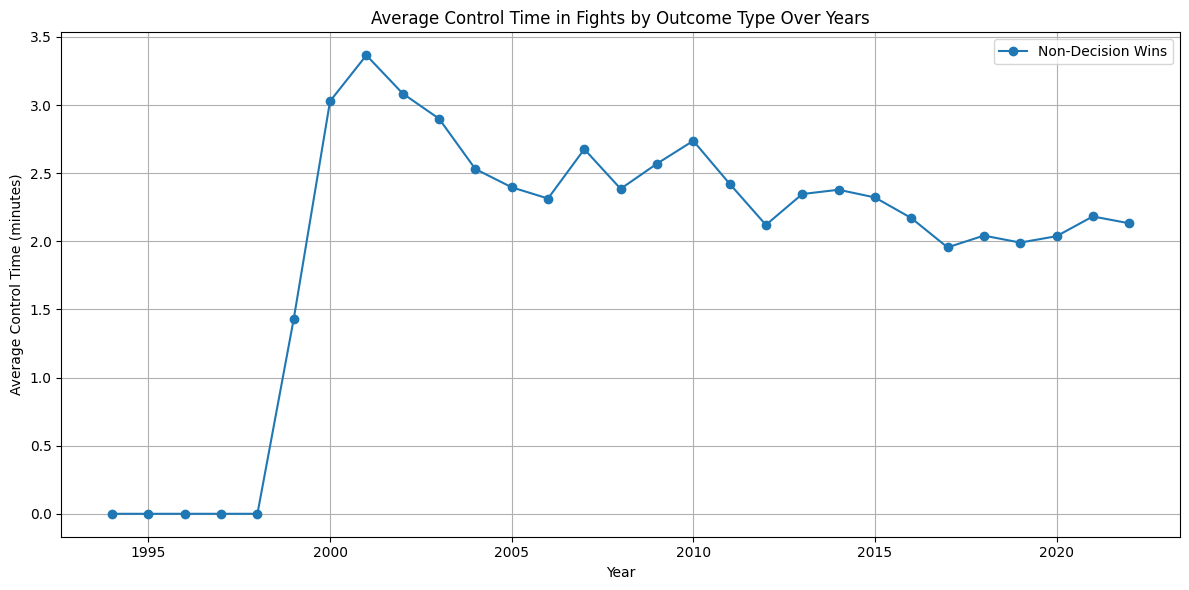

In [6]:
#Plot the average control time for both decision and non-decision wins
df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'])
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year

df_fighter_stat['decision_win'] = (df_fighter_stat['result'] == 1) & (df_fighter_stat['method'].str.contains('Decision', case=False, na=False))
df_fighter_stat['control_min'] = df_fighter_stat['control'] / 60

aggregated_data = df_fighter_stat.groupby(['year', 'decision_win'])['control_min'].mean().unstack()
aggregated_data.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Control Time in Fights by Outcome Type Over Years')
plt.xlabel('Year')
plt.ylabel('Average Control Time (minutes)')
plt.legend(['Non-Decision Wins', 'Decision Wins'])
plt.grid(True)
plt.tight_layout()
plt.show()

As seen on the correlation graph and bar chart, as the years progresses so progresses the rate of decision wins across the promotion. Meaning that fighters are evolving their skillset. Average MMA fighter is not easy to takedown anymore, or submit or KO. Fighters are learning to be more well rounded fighter, that is why they are becoming more and more carefull, leading to increased amount of fights going to the distance.

### In pursuit of decision win, the output of strikes is increasing each year.

The traditional number of "standing strikes" rate is going increasengly up each year, meaning fighters are throwing and landing more and more punches to impress judges and win scores on the score card. The number of "ground strikes" or strikes after landing a takedown is increasing slightly, meaning fighters prefer to keep fight on the feet.

As seen in both graphs of "Significant Strikes Landed (Ground vs. Standing) Over the Years" and "Significant Strikes Landed in Decision Wins (Ground vs. Standing) Over the Years".

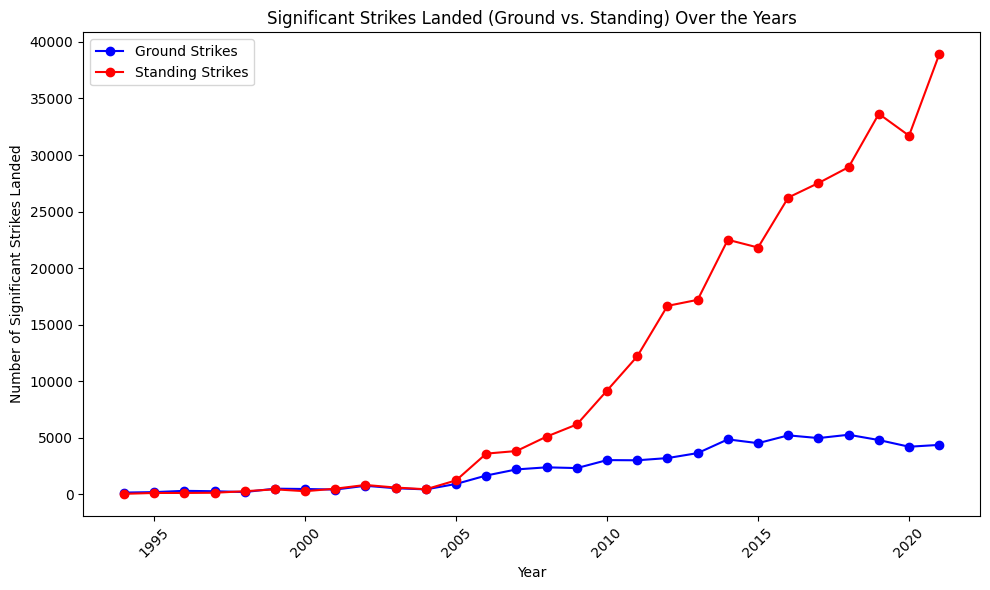

In [7]:
#Plotting the significant strikes landed over the years

df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d')
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year
df_fighter_stat = df_fighter_stat[df_fighter_stat['year'] != 2022]

strikes_summary = df_fighter_stat.groupby('year').agg(
    ground_strikes_landed=pd.NamedAgg(column='ground_strikes_landed', aggfunc='sum'),
    distance_strikes_landed=pd.NamedAgg(column='distance_strikes_landed', aggfunc='sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(strikes_summary['year'], strikes_summary['ground_strikes_landed'], label='Ground Strikes', marker='o', color='blue')
plt.plot(strikes_summary['year'], strikes_summary['distance_strikes_landed'], label='Standing Strikes', marker='o', color='red')
plt.title('Significant Strikes Landed (Ground vs. Standing) Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Significant Strikes Landed')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

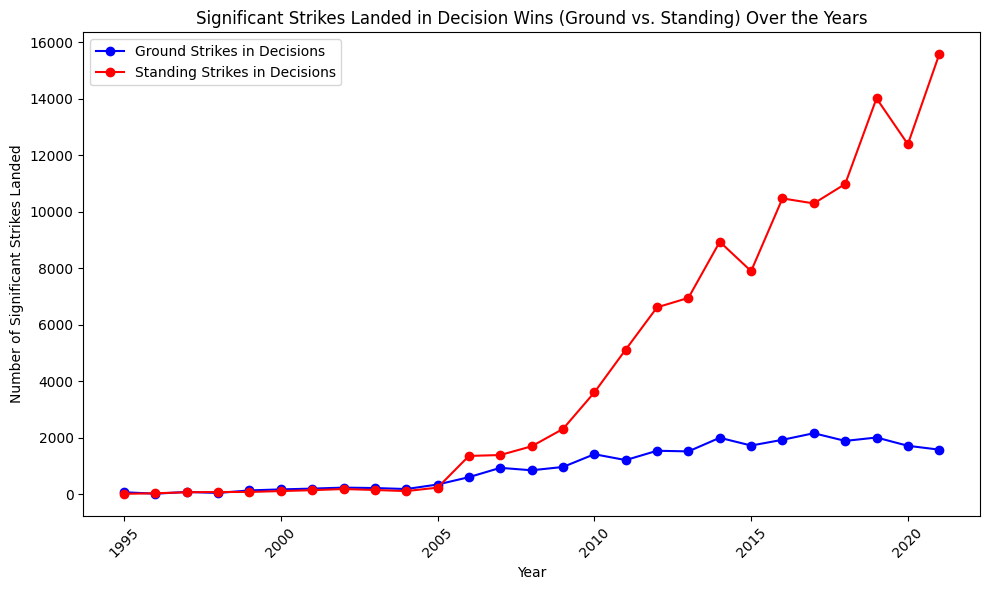

In [8]:
decision_methods = ['U-DEC', 'S-DEC', 'M-DEC']

df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d')
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year

decision_wins_df = df_fighter_stat[(df_fighter_stat['result'] == 1) & (df_fighter_stat['method'].isin(decision_methods))]

# Exclude rows where the year is 2024
decision_wins_df = decision_wins_df[decision_wins_df['year'] != 2022]

# Group by year and sum ground strikes and distance strikes
decision_strikes_summary = decision_wins_df.groupby('year').agg(
    ground_strikes_landed=pd.NamedAgg(column='ground_strikes_landed', aggfunc='sum'),
    distance_strikes_landed=pd.NamedAgg(column='distance_strikes_landed', aggfunc='sum')
).reset_index()

# Plotting the significant strikes landed in decision wins over the years
plt.figure(figsize=(10, 6))
plt.plot(decision_strikes_summary['year'], decision_strikes_summary['ground_strikes_landed'], label='Ground Strikes in Decisions', marker='o', color='blue')
plt.plot(decision_strikes_summary['year'], decision_strikes_summary['distance_strikes_landed'], label='Standing Strikes in Decisions', marker='o', color='red')
plt.title('Significant Strikes Landed in Decision Wins (Ground vs. Standing) Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Significant Strikes Landed')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Increased amount of attemted takedowns.

Also the there is an increased trend of fighters attempting to takedown opponents. Even thou the actual amount of takedown landed is not increasing at the same rate as attempted one, it shows the evolving skill set of fighters, that they are doing everything to win scores.


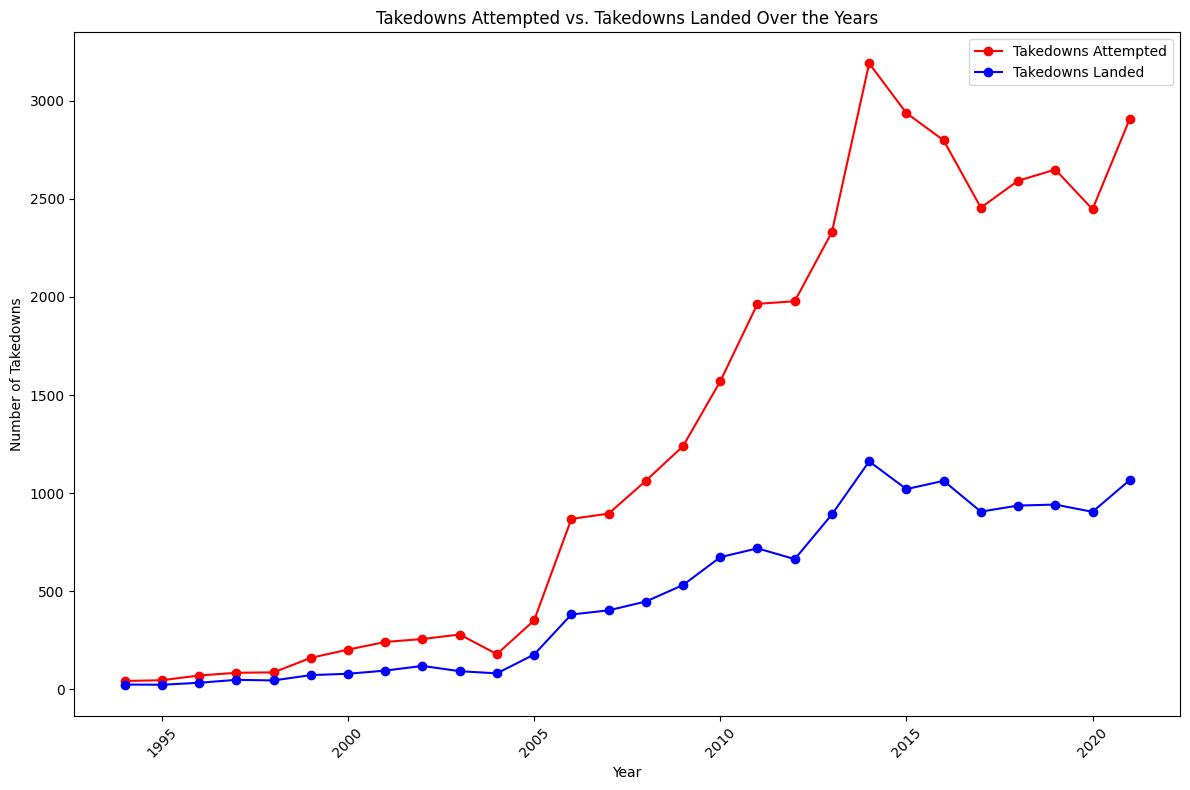

In [9]:

# Load the csv file into a pandas dataframe
df_fighter_stat = pd.read_csv('dataframes/fighter_stat.csv')

# Convert 'date' column to datetime format and extract the year
df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d')
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year

# Exclude rows where the year is 2022
df_fighter_stat = df_fighter_stat[df_fighter_stat['year'] != 2022]

# Group by year and aggregate takedowns landed and attempts
takedowns_by_year = df_fighter_stat.groupby('year').agg(
    takedowns_landed=pd.NamedAgg(column='takedowns_landed', aggfunc='sum'),
    takedowns_attempts=pd.NamedAgg(column='takedowns_attempts', aggfunc='sum')
).reset_index()

# Plotting the takedowns attempted vs. landed over the years
plt.figure(figsize=(12, 8))
plt.plot(takedowns_by_year['year'], takedowns_by_year['takedowns_attempts'], label='Takedowns Attempted', marker='o', color='red')
plt.plot(takedowns_by_year['year'], takedowns_by_year['takedowns_landed'], label='Takedowns Landed', marker='o', color='blue')
plt.title('Takedowns Attempted vs. Takedowns Landed Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Takedowns')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Output of strikes per minute in the fight.

Again, we see that fighters are outputing more strikes to win a decision victory. Also we see decrease in a control time over the years, which is amount of time figther is holding opponent on the ground after takedown, meaning fighters are getting on the feet faster and ready to throw strikes standing up.


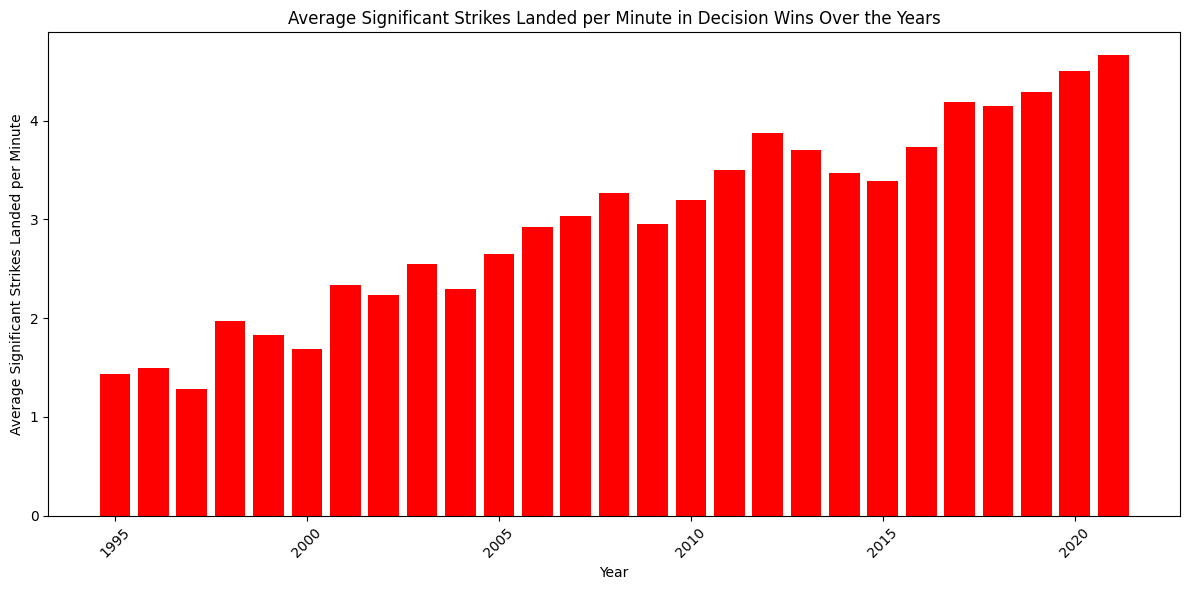

In [10]:
df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d')
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year

# Define the decision types
decision_types = ['U-DEC', 'S-DEC', 'M-DEC']

# Filter for decision wins
df_decisions = df_fighter_stat[(df_fighter_stat['method'].isin(decision_types)) & (df_fighter_stat['result'] == 1)].copy()

# Calculate significant strikes landed per minute
df_decisions.loc[:, 'sig_strikes_landed_per_min'] = df_decisions['sig_strikes_landed'] / (df_decisions['total_comp_time'] / 60)

# Group by year and calculate the average significant strikes landed per minute
avg_strikes_by_year = df_decisions.groupby('year')['sig_strikes_landed_per_min'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(avg_strikes_by_year['year'], avg_strikes_by_year['sig_strikes_landed_per_min'], color='red')
plt.title('Average Significant Strikes Landed per Minute in Decision Wins Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Significant Strikes Landed per Minute')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


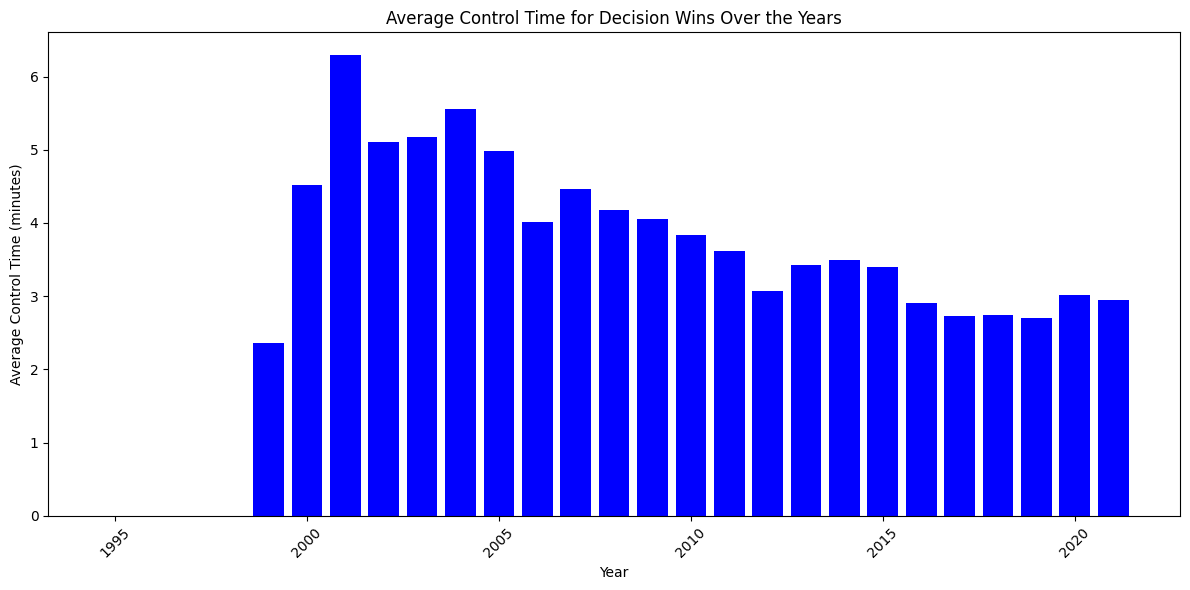

In [11]:
df_fighter_stat['control_min'] = df_fighter_stat['control'] / 60

# Filter for decision wins and calculate the average control time by year
avg_control_by_year = df_fighter_stat[df_fighter_stat['method'].isin(decision_types)].groupby('year')['control_min'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(avg_control_by_year['year'], avg_control_by_year['control_min'], color='blue')
plt.title('Average Control Time for Decision Wins Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Control Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df_fighter_stat = pd.read_csv('dataframes/fighter_stat.csv')

# Convert the date column to datetime and extract the year
df_fighter_stat['date'] = pd.to_datetime(df_fighter_stat['date'], format='%Y-%m-%d')
df_fighter_stat['year'] = df_fighter_stat['date'].dt.year

# Filter for decision wins and specific decision methods
decision_methods = ['U-DEC', 'S-DEC', 'M-DEC']
df_decisions = df_fighter_stat[(df_fighter_stat['result'] == 1) & (df_fighter_stat['method'].isin(decision_methods))].copy()

# Create the 'sig_strikes_landed_per_min' column safely using .loc
df_decisions.loc[:, 'sig_strikes_landed_per_min'] = df_decisions['sig_strikes_landed'] / (df_decisions['total_comp_time'] / 60)

# Group by year and calculate average metrics for decision wins
avg_metrics_for_decision_wins = df_decisions.groupby('year').agg({
    'sig_strikes_landed_per_min': 'mean',
    'takedowns_attempts': 'mean',
    'takedowns_landed': 'mean',
    'control': lambda x: x.mean() / 60  # Convert control time to minutes
}).reset_index()

# Extract the averages
avg_sig_strikes_landed_per_min = avg_metrics_for_decision_wins['sig_strikes_landed_per_min'].mean()
avg_takedowns_attempts = avg_metrics_for_decision_wins['takedowns_attempts'].mean()
avg_takedowns_landed = avg_metrics_for_decision_wins['takedowns_landed'].mean()
avg_control_time_min = avg_metrics_for_decision_wins['control'].mean()

# Convert control time into minutes and seconds
control_minutes = int(avg_control_time_min)
control_seconds = int((avg_control_time_min - control_minutes) * 60)

# Print the strategy based on the calculated averages
print(f"To increase your chances of winning a decision in UFC, consider the following strategy:")
print(f"- Land an average of {avg_sig_strikes_landed_per_min:.2f} significant strikes per minute.")
print(f"- Attempt around {avg_takedowns_attempts:.2f} takedowns during the fight.")
print(f"- Ensure you successfully land about {avg_takedowns_landed:.2f} of those takedown attempts.")
print(f"- Aim to control your opponent for an average of {control_minutes} minutes and {control_seconds} seconds throughout the fight.")

To increase your chances of winning a decision in UFC, consider the following strategy:
- Land an average of 3.05 significant strikes per minute.
- Attempt around 4.55 takedowns during the fight.
- Ensure you successfully land about 2.21 of those takedown attempts.
- Aim to control your opponent for an average of 4 minutes and 53 seconds throughout the fight.


### Formula to win a decision fight.

Now we are coming to the final step of seeing the "perfect" formula of securing victory in UFC fight, on average across all weight classes, you need as fighter to produce:
- Land an average of 3.82 significant strikes per minute.
- Attempt around 4.85 takedowns during the fight.
- Ensure you successfully land about 2.18 of those takedown attempts.
- Aim to control your opponent for an average of 4.56 minutes throughout the fight.

Meaning MMA fights evolve to the point, where fighter have to not only to keep increasing outputs of strikes per round, but also aim for more diversified approach such as landing a takedown and controlling an opponent on the ground.

### Conclusion

This analysis reveals that the rise in decision wins is closely tied to the increasing number of active fighters in the UFC. The data suggests a strategic shift towards more technical and calculated approaches to fighting, emphasizing the importance of a well-rounded skill set for securing decision victories. By adhering to the identified formula—optimizing significant strikes, takedowns, and control time—fighters can enhance their chances of winning by decision in today's competitive UFC environment.